<div align="center">
    <font color="0F5298" size="7">
        Deep Learning <br>
    </font>
    <font color="2565AE" size="5">
        CE Department <br>
        Spring 2024 - Prof. Soleymani Baghshah <br>
    </font>
    <font color="3C99D" size="5">
        HW2 Practical <br>
    </font>
    <font color="696880" size="5">
        40 Points
    </font>
</div>


You'll be building your own U-Net, a type of CNN designed for quick, precise image segmentation, and using it to predict a label for every single pixel in an image - in this case, an image from a self-driving car dataset.

This type of image classification is called semantic image segmentation. It's similar to object detection in that both ask the question: "What objects are in this image and where in the image are those objects located?," but where object detection labels objects with bounding boxes that may include pixels that aren't part of the object, semantic image segmentation allows you to predict a precise mask for each object in the image by labeling each pixel in the image with its corresponding class. The word “semantic” here refers to what's being shown, so for example the “Car” class is indicated below by the dark blue mask, and "Person" is indicated with a red mask:


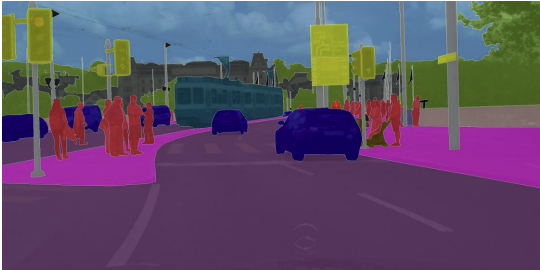 <br>
<u><b>Figure 1</u></b>: Example of a segmented image <br>

As you might imagine, region-specific labeling is a pretty crucial consideration for self-driving cars, which require a pixel-perfect understanding of their environment so they can change lanes and avoid other cars, or any number of traffic obstacles that can put peoples' lives in danger.

By the time you finish this notebook, you'll be able to:

* Build your own U-Net
* Explain the difference between a regular CNN and a U-net
* Implement semantic image segmentation on the CARLA self-driving car dataset
* Apply sparse categorical crossentropy for pixelwise prediction

Onward, to this grand and glorious quest!

## Downloading Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown
!pip install torch-summary
!gdown --id 11r4jZIlLMaX8b36lESUpPRiQi_GIcOA3

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=11r4jZIlLMaX8b36lESUpPRiQi_GIcOA3
From (redirected): https://drive.google.com/uc?id=11r4jZIlLMaX8b36lESUpPRiQi_GIcOA3&confirm=t&uuid=ee5d5259-bd5a-43cc-a781-df2cae7a4ee0
To: /content/Files.zip
100% 545M/545M [00:11<00:00, 47.6MB/s]


In [2]:
!unzip Files.zip ;

Archive:  Files.zip
  inflating: Files/data/CameraRGB/002128.png  
  inflating: Files/data/CameraRGB/008579.png  
  inflating: Files/data/CameraRGB/015232.png  
  inflating: Files/data/CameraRGB/006878.png  
  inflating: Files/data/CameraRGB/008104.png  
  inflating: Files/data/CameraRGB/002281.png  
  inflating: Files/data/CameraRGB/004063.png  
  inflating: Files/data/CameraRGB/049745.png  
  inflating: Files/data/CameraRGB/013414.png  
  inflating: Files/data/CameraRGB/011470.png  
  inflating: Files/data/CameraRGB/022243.png  
  inflating: Files/data/CameraRGB/049187.png  
  inflating: Files/data/CameraRGB/011056.png  
  inflating: Files/data/CameraRGB/049727.png  
  inflating: Files/data/CameraRGB/006896.png  
  inflating: Files/data/CameraRGB/012028.png  
  inflating: Files/data/CameraRGB/009569.png  
  inflating: Files/data/CameraRGB/007787.png  
  inflating: Files/data/CameraRGB/010561.png  
  inflating: Files/data/CameraRGB/064397.png  
  inflating: Files/data/CameraRGB/015016

<a name='1'></a>
## 1 - Packages

Run the cell below to import all the libraries you'll need:

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms, io
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

### Chack if GPU is available

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
ls /content/Files/data

CameraMask/  CameraRGB/


<a name='2'></a>
## 2 - Load the Data

In [6]:
path = '/content/Files'
image_path = os.path.join(path, 'data/CameraRGB/')
mask_path = os.path.join(path, 'data/CameraMask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [7]:
len(image_list)

1060

### Check out the some of the unmasked and masked images from the dataset:

After you are done exploring, revert back to `N=2`. Otherwise the autograder will throw a `list index out of range` error.

<ipython-input-8-6f04f61f89db>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
<ipython-input-8-6f04f61f89db>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


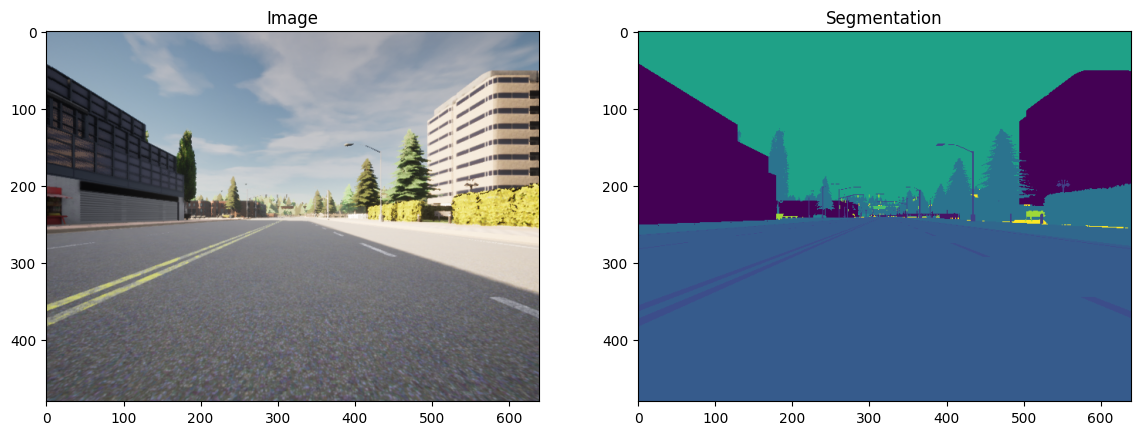

In [8]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')
plt.show()

<a name='2-2'></a>
### 2.2 - Preprocess Your Data



In [9]:
class Segmentation_Dataset(Dataset):
    def __init__(self, ImagesDirectory, MasksDirectory):
        self.ImagesDirectory = ImagesDirectory
        self.MasksDirectory = MasksDirectory
        self.images = os.listdir(self.ImagesDirectory)
        self.masks = os.listdir(self.MasksDirectory)
        self.mask_transforms = transforms.Compose([
            transforms.Resize((192, 256), interpolation=transforms.InterpolationMode.NEAREST)
        ])
        self.image_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((192, 256), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[0:3])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_name = self.images[index]

        img_path = os.path.join(self.ImagesDirectory, img_name)
        img = io.read_file(img_path)
        img = io.decode_png(img)

        mask_path = os.path.join(self.MasksDirectory, img_name)
        mask = io.read_image(mask_path)
        mask, _ = torch.max(mask[0:3], dim=0, keepdim=True)
        img, mask = self.image_transforms(img), self.mask_transforms(mask)
        return {"IMAGE": img , "MASK": mask}

<a name='2-3'></a>
### 2.3 - Hyper-parameters and Optimizer

In [10]:
EPOCHS = 30
BATCH_SIZE = 64
LR = 1e-3
B1 = 0.9
B2 = 0.999

<a name='3'></a>
## 3 - U-Net

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks.

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used.

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough.

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways.  Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting.

<a name='3-1'></a>
### 3.1 - Model Details

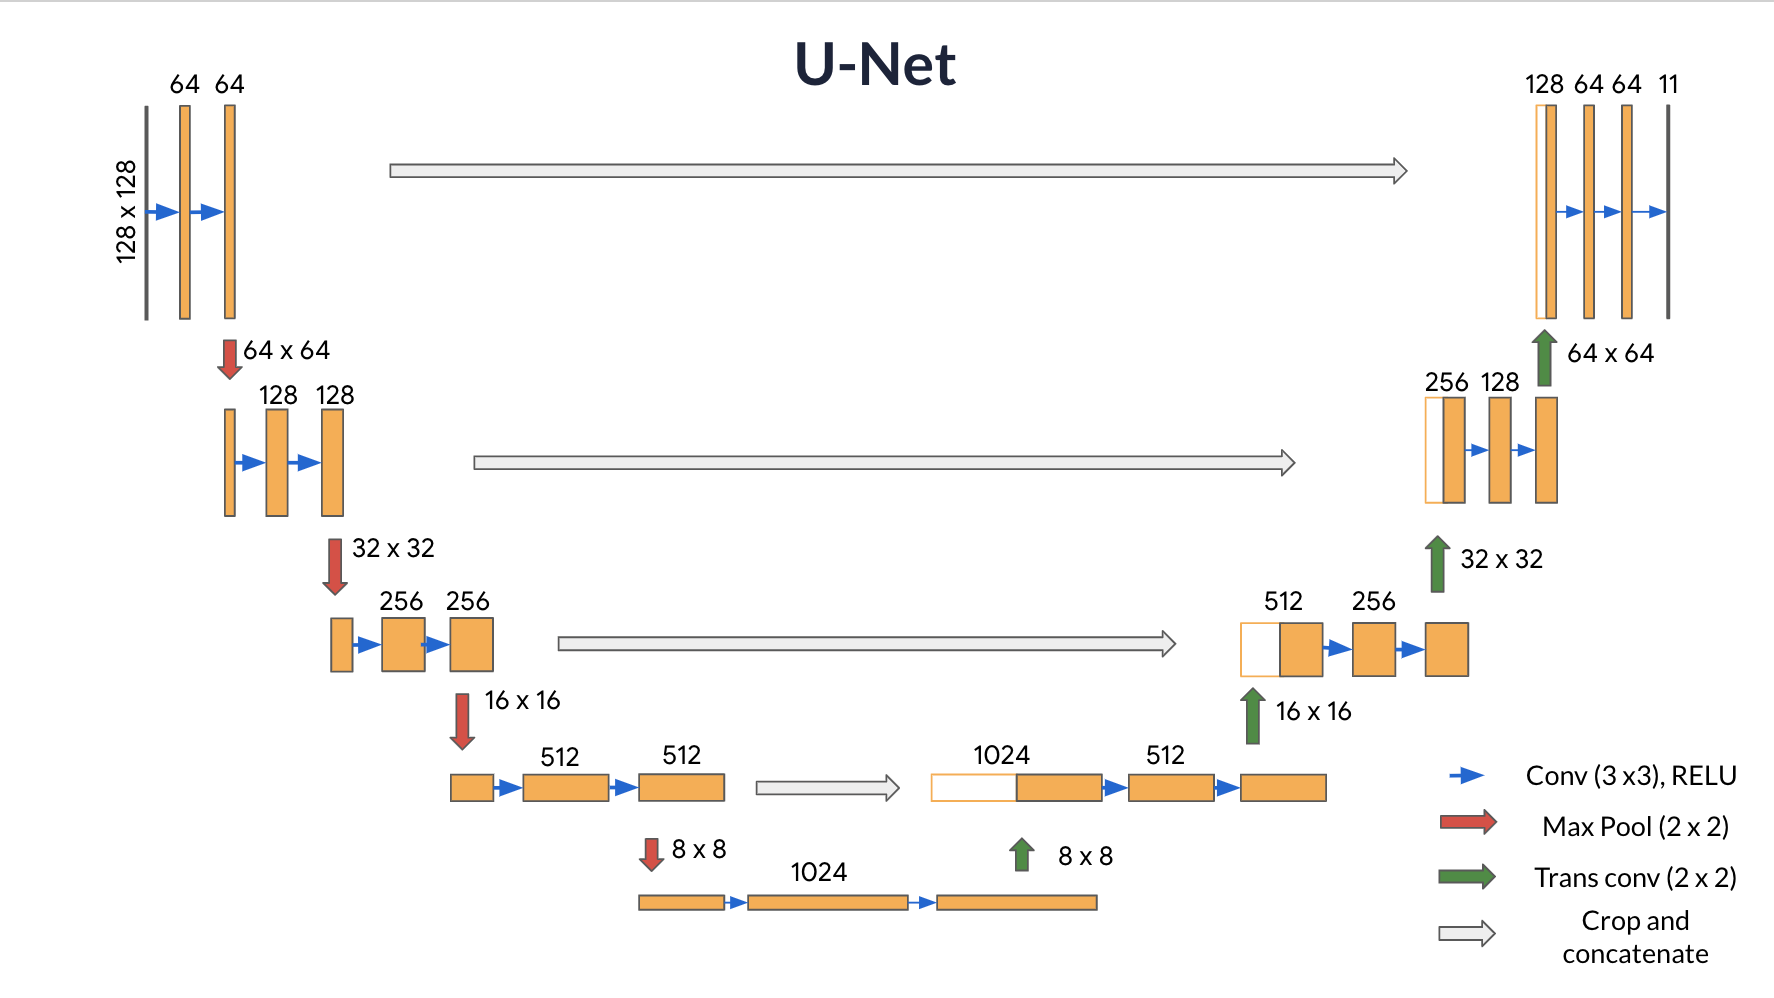<br>
<u><b> Figure 2 </u></b>: U-Net Architecture<br>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 valid padding convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection.

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class.

The U-Net network has 23 convolutional layers in total.

#### Important Note:
The figures shown in the assignment for the U-Net architecture depict the layer dimensions and filter sizes as per the original paper on U-Net with smaller images. However, due to computational constraints for this assignment, you will code only half of those filters. The purpose of showing you the original dimensions is to give you the flavour of the original U-Net architecture. The important takeaway is that you multiply by 2 the number of filters used in the previous step. The notebook includes all of the necessary instructions and hints to help you code the U-Net architecture needed for this assignment.

<a name='3-2'></a>
### 3.2 - Convolution Blocks
In both the encoder and the decoder, we see repeated applications of 2D convolution blocks, each followed by ReLU activation. In the following cell, you'll implement these building blocks.

In [11]:
import torch.nn as nn

class Block(nn.Module):

    def __init__(self, in_ch, out_ch):
        """
        Initializes the Block with the specified input and output channels.

        Args:
            in_ch (int): Number of input channels.
            out_ch (int): Number of output channels.
        """
        super().__init__()

        # TODO:
        #    Create a list of layers that includes:
        #    - A 2D convolutional layer with in_ch input channels and out_ch
        #      output channels, using a kernel size of 3 and 'same' padding.
        #    - A ReLU activation function.
        #    - A second 2D convolutional layer with out_ch input and output
        #      channels, using a kernel size of 3 and 'same' padding.
        #    - A second ReLU activation function.

        layers = [
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU()
        ]

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass through the convolutional block.

        Args:
            x (torch.Tensor): Input tensor of shape (N, in_ch, H, W), where N is the batch size,
                              H is the height, and W is the width.

        Returns:
            torch.Tensor: Output tensor of shape (N, out_ch, H, W).
        """
        return self.conv(x)



In [12]:
# test your implementation
enc_block = Block(1, 64)
x         = torch.randn(1, 1, 128, 128)
enc_block(x).shape

torch.Size([1, 64, 128, 128])

<a name='3-2'></a>
### 3.3- Encoder (Downsampling Block)

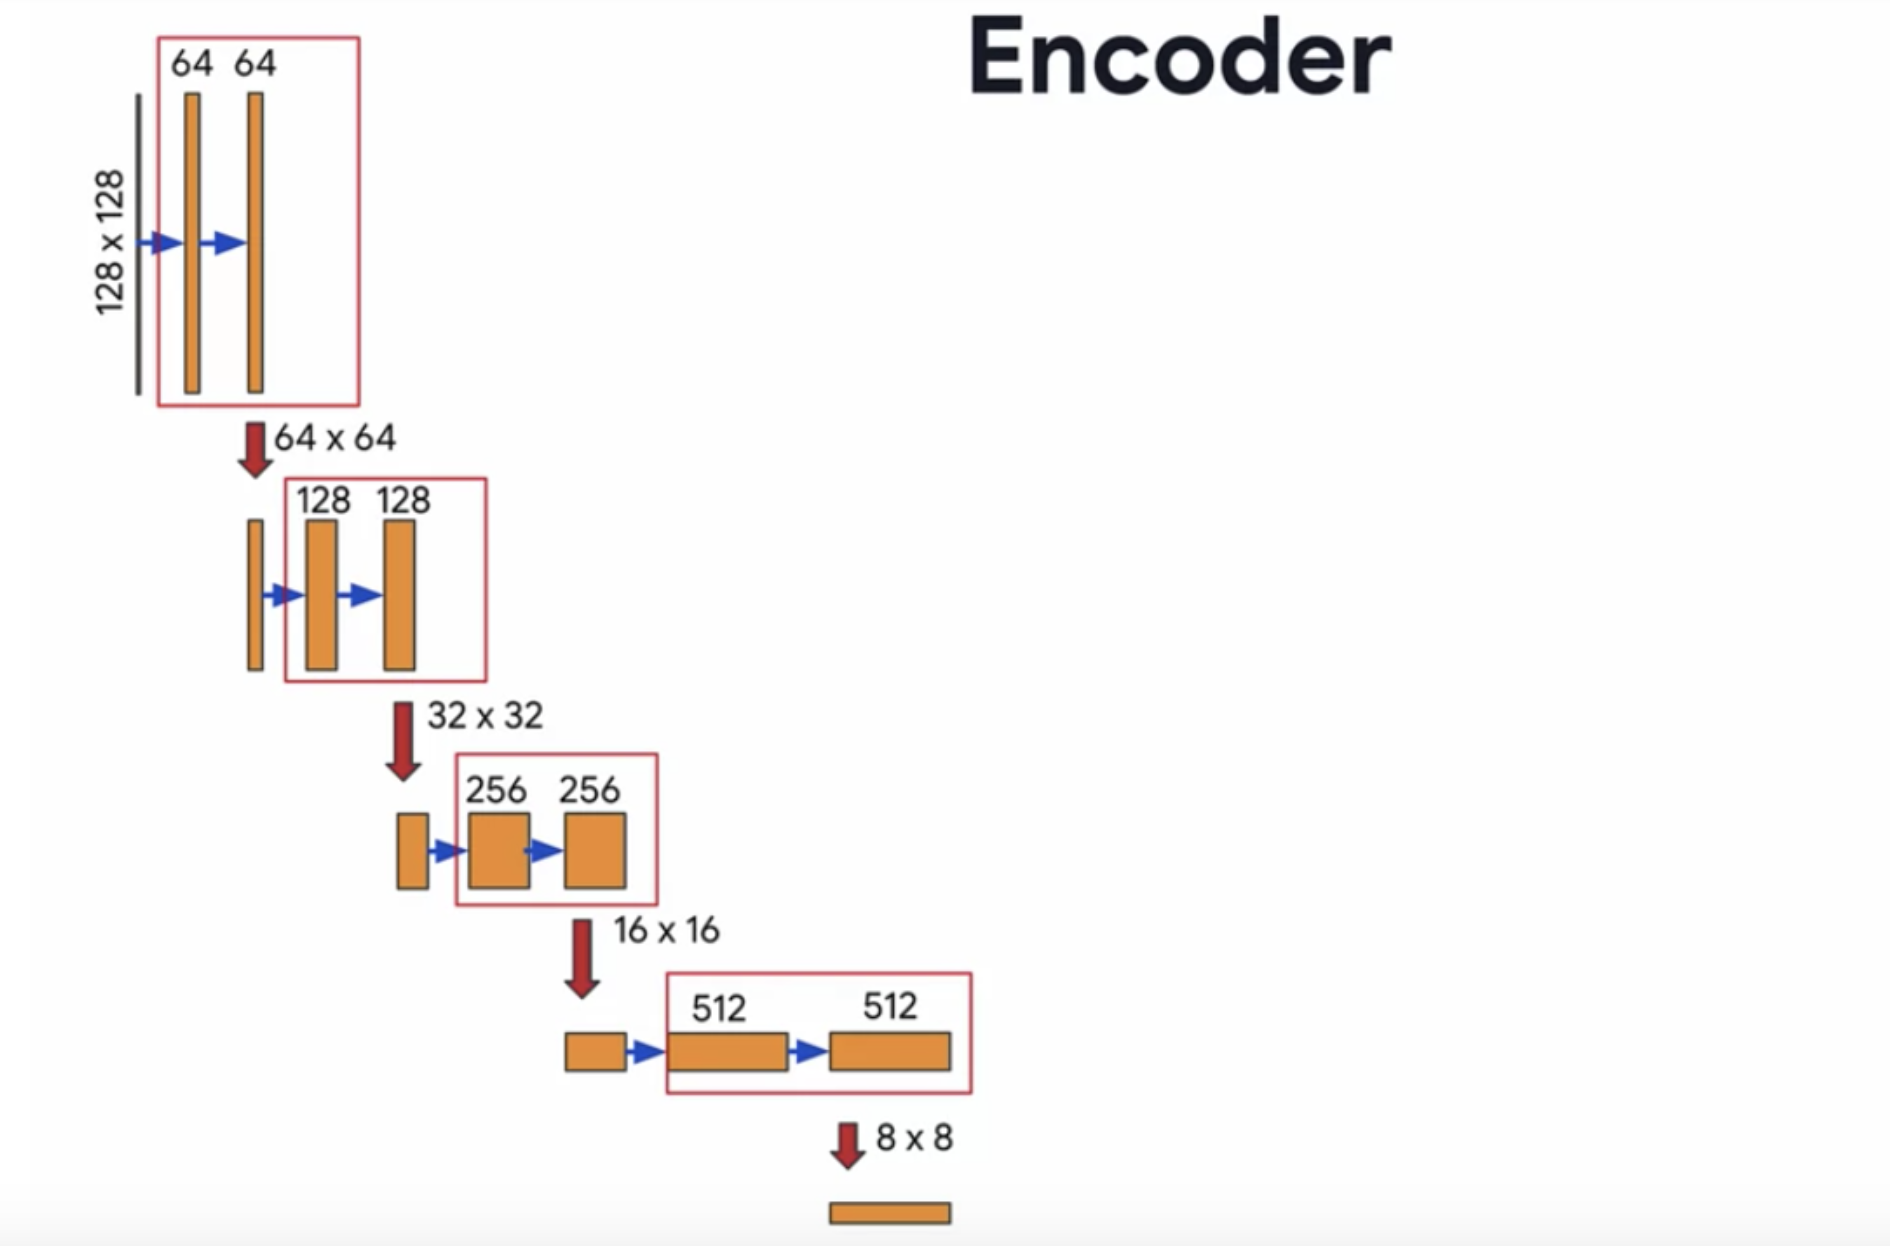<br>
<u><b>Figure 3</u></b>: The U-Net Encoder up close <br>

<a name='3-2'></a>
### 3.3 - Encoder (Downsampling Block)

So far we have implemented the convolution operations but not the downsampling part. The contractive path consists of the repeated application of two 3x3 convolutions, each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels.

We now need to add max pooling after each block to compose a list of downsampling blocks. Note that, we need to store the output of convolutional blocks before the application of max pooling. The output of convolutional blocks will be later used in the expansive path.

In [13]:
import torch.nn as nn

class Encoder(nn.Module):


    def __init__(self, chs=(3, 64, 128, 256, 512, 1024)):
        """
        Initializes the Encoder with the specified channel sizes.

        Args:
            chs (tuple): A tuple containing the number of channels for each
            layer in the encoder.
        """
        super().__init__()

        # TODO:
        #    Create a list of downsampling blocks using the Block class.
        #    - Use a ModuleList to store the blocks.
        #    - Each block should take the number of input channels from chs[i]
        #      and output channels from chs[i+1].

        self.enc_blocks = nn.Sequential(*[Block(chs[i], chs[i+1]) for i in range(5)])

        # TODO:
        #    Initialize a max pooling layer with a kernel size of 2 and stride
        #    of 2 for downsampling.

        self.pool = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        """
        Forward pass through the encoder.

        Args:
            x (torch.Tensor): Input tensor of shape (N, C, H, W), where N is
            the batch size, C is the number of input channels, H is the height,
            and W is the width.

        Returns:
            list: A list of feature maps from each downsampling block.
        """
        ftr1 = self.enc_blocks[0](x)
        down1 = self.pool(ftr1)

        ftr2 = self.enc_blocks[1](down1)
        down2 = self.pool(ftr2)

        ftr3 = self.enc_blocks[2](down2)
        down3 = self.pool(ftr3)

        ftr4 = self.enc_blocks[3](down3)
        down4 = self.pool(ftr4)

        ftr5 = self.enc_blocks[4](down4)

        ftrs =[ftr1, ftr2, ftr3, ftr4, ftr5]

        # TODO:
        #    Iterate through each block in enc_blocks:
        #    - Pass the input tensor x through the block.
        #    - Append the output feature map to the ftrs list.
        #    - Apply the max pooling operation to downsample the feature map.

        return ftrs


In [14]:
# test your implementation
encoder = Encoder()
# input image
x    = torch.randn(1, 3, 128, 128)
ftrs = encoder(x)
for ftr in ftrs: print(ftr.shape)

torch.Size([1, 64, 128, 128])
torch.Size([1, 128, 64, 64])
torch.Size([1, 256, 32, 32])
torch.Size([1, 512, 16, 16])
torch.Size([1, 1024, 8, 8])


<a name='3-3'></a>
### 3.4 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

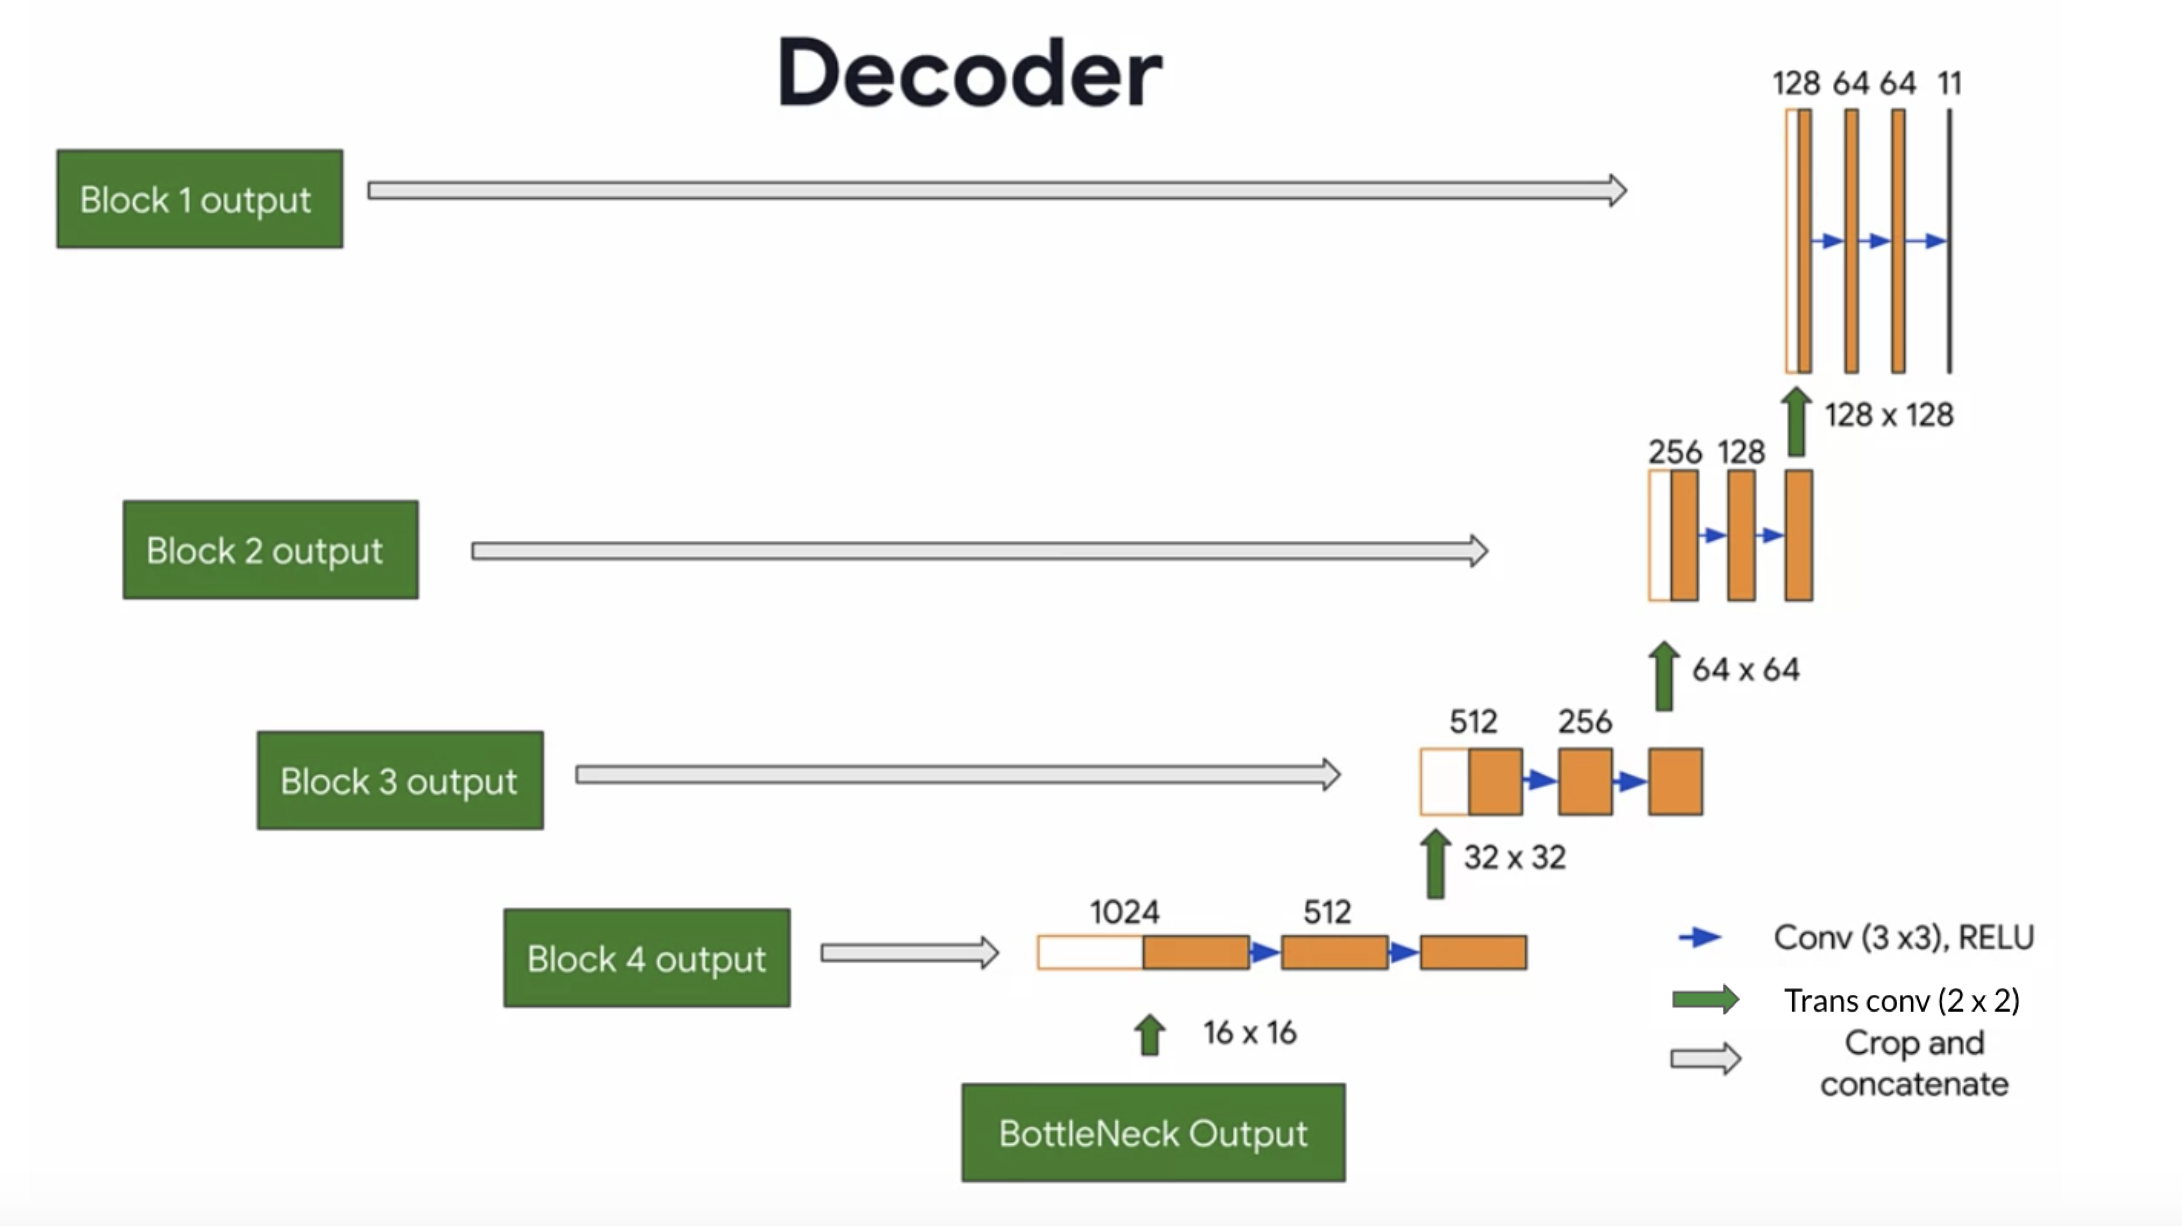<br>
<u><b>Figure 4</u></b>: The U-Net Decoder up close <br>

The Decoder, is the expansive path of the U-Net Architecture.

Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU.

Note that we have already implemented the part where two 3x3 convolutions occur followed by ReLU activation in Block. All we need to do to implement the Decoder is to add the “up-convolution” and the feature concatenation.

Note that in PyTorch, the ConvTranspose2d operation performs the “up-convolution”. It accepts parameters like in_channels, out_channels, kernel_size and stride amongst others.

In [15]:
import torch.nn as nn
import torch
class Decoder(nn.Module):


    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        """
        Initializes the Decoder with the specified channel sizes.

        Args:
            chs (tuple): A tuple containing the number of channels for each
            layer in the decoder.
        """
        super().__init__()
        self.chs = chs

        # TODO:
        #    Create a list of transposed convolution layers for upsampling.
        #    - Use a ModuleList to store the layers.
        #    - Each layer should take the number of input channels from chs[i]
        #      and output channels from chs[i+1].
        #    - Use a kernel size of 4, stride of 2, and padding of 1

        self.upconvs = nn.Sequential(*[nn.ConvTranspose2d(self.chs[i], self.chs[i+1], kernel_size=4, stride=2, padding=1) for i in range(4)])

        # TODO:
        #    Create a list of downsampling blocks using the Block class for the
        #    decoder.
        #    - Use a ModuleList to store the blocks.
        #    - Each block should take the number of input channels from chs[i]
        #    and output channels from chs[i+1].

        self.dec_blocks = nn.Sequential(*[Block(self.chs[i], self.chs[i+1]) for i in range(4)])

    def forward(self, x, enc_ftrs):
        """
        Forward pass through the decoder.

        Args:
            x (torch.Tensor): Input tensor of shape (N, C, H, W), where N is the
                              batch size, C is the number of input channels,
                              H is the height, and W is the width.
            enc_ftrs (list): A list of feature maps from the encoder to concatenate
                             with during decoding.

        Returns:
            torch.Tensor: Output tensor of shape (N, out_channels, H_out, W_out) after decoding.
        """


        # TODO:
        #    Iterate through each index in the range of the number of channels minus one:
        #    - Apply the corresponding transposed convolution layer to the input tensor x.
        #    - Concatenate the result with the corresponding feature map from
        #      enc_ftrs along the channel dimension.

        #    - Pass the concatenated tensor through the corresponding decoding block.

        for i in range(len(self.chs) - 1):
            x = self.upconvs[i](x)
            x = torch.cat([x, enc_ftrs[i]], dim=1)
            x = self.dec_blocks[i](x)

        return x


In [16]:
# test your implementation
decoder = Decoder()
decoder(ftrs[::-1][0], ftrs[::-1][1:]).shape

torch.Size([1, 64, 128, 128])

<a name='3-4'></a>
### 3.4 - Build the Model

This is where you'll put it all together, by chaining the encoder, bottleneck, and decoder! You'll need to specify the number of output channels, which for this particular set would be 23. That's because there are 23 possible labels for each pixel in this self-driving car dataset.

In [17]:
import torch.nn as nn

class UNet(nn.Module):


    def __init__(self, enc_chs=(3, 64, 128, 256, 512, 1024), dec_chs=(1024, 512, 256, 128, 64), num_class=2):
        """
        Initializes the U-Net with the specified channel sizes and number of classes.

        Args:
            enc_chs (tuple): A tuple containing the number of channels for each layer in the encoder.
            dec_chs (tuple): A tuple containing the number of channels for each layer in the decoder.
            num_class (int): The number of output classes for segmentation.
        """
        super().__init__()
        self.encoder = Encoder(enc_chs)
        self.decoder = Decoder(dec_chs)

        # TODO:
        #    Initialize the final convolutional layer (head) to map the output
        #    of the decoder to the number of classes.
        #    - Use a kernel size of 1 and 'same' padding.

        self.head = nn.Conv2d(dec_chs[-1], 23, kernel_size=1)
    def forward(self, x):
        """
        Forward pass through the U-Net.

        Args:
            x (torch.Tensor): Input tensor of shape (N, C, H, W), where N is the
                              batch size, C is the number of input channels,
                              H is the height, and W is the width.

        Returns:
            torch.Tensor: Output tensor of shape (N, num_class, H_out, W_out)
                          representing the segmentation map.
        """

        # TODO:
        #  - Pass the input tensor x through the encoder to obtain the feature maps.
        #  - Pass the last feature map from the encoder and the reversed list of
        #    feature maps to the decoder.
        #  - Pass the output of the decoder through the final convolutional layer
        #    (head) to get the segmentation map.
        ftrs = self.encoder(x)
        out = self.decoder(ftrs[::-1][0], ftrs[::-1][1:])
        out = self.head(out)
        return out


### Check out the model summary below!

In [18]:
unet = UNet(enc_chs=(3, 32, 64,128,256,512), dec_chs=(512, 256, 128, 64, 32), num_class=23).to(device)
summary(unet, (3, 192, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1-1                           [-1, 32, 192, 256]        --
|    └─Sequential: 2                     []                        --
|    |    └─Block: 3-1                   [-1, 32, 192, 256]        10,144
|    └─MaxPool2d: 2-1                    [-1, 32, 96, 128]         --
|    └─Sequential: 2                     []                        --
|    |    └─Block: 3-2                   [-1, 64, 96, 128]         55,424
|    └─MaxPool2d: 2-2                    [-1, 64, 48, 64]          --
|    └─Sequential: 2                     []                        --
|    |    └─Block: 3-3                   [-1, 128, 48, 64]         221,440
|    └─MaxPool2d: 2-3                    [-1, 128, 24, 32]         --
|    └─Sequential: 2                     []                        --
|    |    └─Block: 3-4                   [-1, 256, 24, 32]         885,248
|    └─MaxPool2d: 2-4                    [-1, 256, 12, 16]         

Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1-1                           [-1, 32, 192, 256]        --
|    └─Sequential: 2                     []                        --
|    |    └─Block: 3-1                   [-1, 32, 192, 256]        10,144
|    └─MaxPool2d: 2-1                    [-1, 32, 96, 128]         --
|    └─Sequential: 2                     []                        --
|    |    └─Block: 3-2                   [-1, 64, 96, 128]         55,424
|    └─MaxPool2d: 2-2                    [-1, 64, 48, 64]          --
|    └─Sequential: 2                     []                        --
|    |    └─Block: 3-3                   [-1, 128, 48, 64]         221,440
|    └─MaxPool2d: 2-3                    [-1, 128, 24, 32]         --
|    └─Sequential: 2                     []                        --
|    |    └─Block: 3-4                   [-1, 256, 24, 32]         885,248
|    └─MaxPool2d: 2-4                    [-1, 256, 12, 16]         

<a name='3-6'></a>
### 3.6 - Dataset Handling

Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible.

In [19]:
dataloader = DataLoader(Segmentation_Dataset(image_path, mask_path), batch_size=BATCH_SIZE, shuffle=True)

In [20]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].permute(1, 2, 0))
        plt.axis('off')
    plt.show()

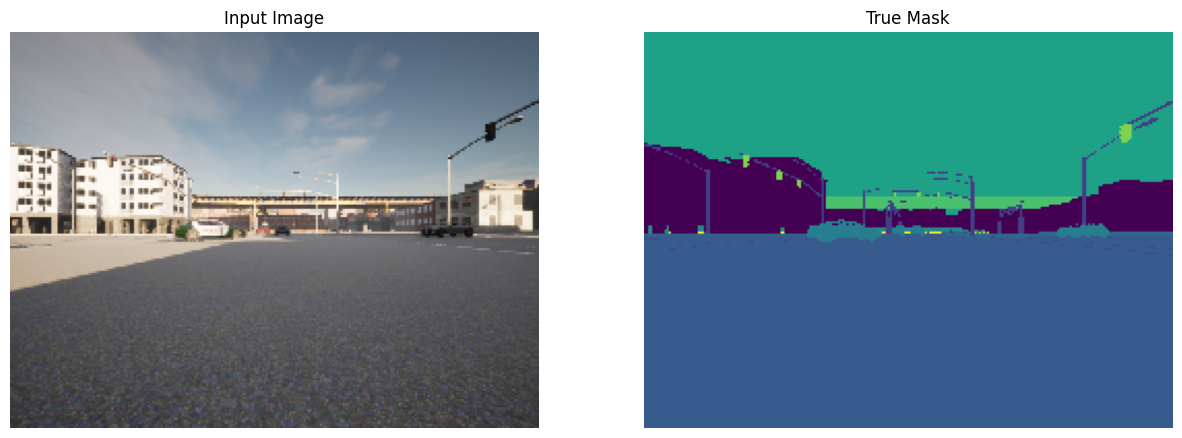

In [21]:
# Get the first batch of data
data_iter = iter(dataloader)
first_batch = next(data_iter)

# Extract the first image and mask
first_image = first_batch['IMAGE'][0]  # First image from the batch
first_mask = first_batch['MASK'][0]    # First mask from the batch

# Display the image and mask
display([first_image, first_mask])

<a name='3-7'></a>
### 3.7 - Loss Function

In semantic segmentation, you need as many masks as you have object classes. In the dataset you're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability.

This is different from categorical crossentropy, where the labels should be one-hot encoded (just 0s and 1s). Here, you'll use sparse categorical crossentropy as your loss function, to perform pixel-wise multiclass prediction. Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with lots of classes.

In [22]:
criterion = nn.CrossEntropyLoss()

In [23]:
optimizer = torch.optim.Adam(unet.parameters(), lr=LR, betas=(B1, B2))

<a name='4'></a>
## 4 - Train the Model

In [24]:
losses = []
for epoch in range(EPOCHS):
    epoch_losses = []
    for i, batch in enumerate(dataloader):

        images = batch["IMAGE"].to(device)
        masks = batch["MASK"].to(device).long().squeeze(1)

        optimizer.zero_grad()
        preds = unet(images)
        loss = nn.CrossEntropyLoss()(preds, masks)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

        print(f'EPOCH#{epoch},\t Batch#{i},\t Loss:{loss.item()}')
    losses.append(np.mean(epoch_losses))

EPOCH#0,	 Batch#0,	 Loss:3.0537776947021484
EPOCH#0,	 Batch#1,	 Loss:3.045497179031372
EPOCH#0,	 Batch#2,	 Loss:3.034057855606079
EPOCH#0,	 Batch#3,	 Loss:3.0129101276397705
EPOCH#0,	 Batch#4,	 Loss:2.969003677368164
EPOCH#0,	 Batch#5,	 Loss:2.151148557662964
EPOCH#0,	 Batch#6,	 Loss:50.79623031616211
EPOCH#0,	 Batch#7,	 Loss:2.0342190265655518
EPOCH#0,	 Batch#8,	 Loss:2.8206474781036377
EPOCH#0,	 Batch#9,	 Loss:2.9094717502593994
EPOCH#0,	 Batch#10,	 Loss:2.9342947006225586
EPOCH#0,	 Batch#11,	 Loss:2.929304838180542
EPOCH#0,	 Batch#12,	 Loss:2.9199187755584717
EPOCH#0,	 Batch#13,	 Loss:2.932451009750366
EPOCH#0,	 Batch#14,	 Loss:2.9239282608032227
EPOCH#0,	 Batch#15,	 Loss:2.910285234451294
EPOCH#0,	 Batch#16,	 Loss:2.905543565750122
EPOCH#1,	 Batch#0,	 Loss:2.901573419570923
EPOCH#1,	 Batch#1,	 Loss:2.8995275497436523
EPOCH#1,	 Batch#2,	 Loss:2.865388870239258
EPOCH#1,	 Batch#3,	 Loss:2.8713159561157227
EPOCH#1,	 Batch#4,	 Loss:2.858474016189575
EPOCH#1,	 Batch#5,	 Loss:2.8356428146

<a name='4-1'></a>
### 4.1 - Create Predicted Masks

Now, define a function that uses `torch.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [41]:
def create_mask(pred_mask):

    ## TODO
    pred_mask = torch.argmax(pred_mask, dim=1)

    return pred_mask

<a name='4-2'></a>
### 4.2 - Plot Model Accuracy

Let's see how your model did!

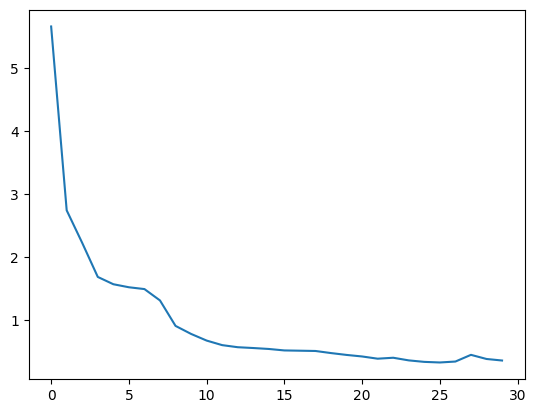

In [30]:
plt.plot(np.arange(len(losses)), losses)

<a name='4-3'></a>
### 4.3 - Show Predictions

Next, check your predicted masks against the true mask and the original input image:

In [ ]:
def display(display_list):
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    plt.figure(figsize=(15, 5))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if display_list[i].dim() == 3:
            plt.imshow(display_list[i].permute(1, 2, 0))
        else:
            plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()


In [42]:
def show_predictions(dataloader, device, num=1):
    """
    Displays the first image of each of the num batches
    """
    for i, batch in enumerate(dataloader):
        IMG = batch["IMAGE"][:1].to(device)
        MASK = batch["MASK"][:1].to(device)

        pred_mask = unet(IMG)
        display([IMG[0].cpu(), MASK[0].cpu(), create_mask(pred_mask)[0].cpu()])

        if i >= num:
            break

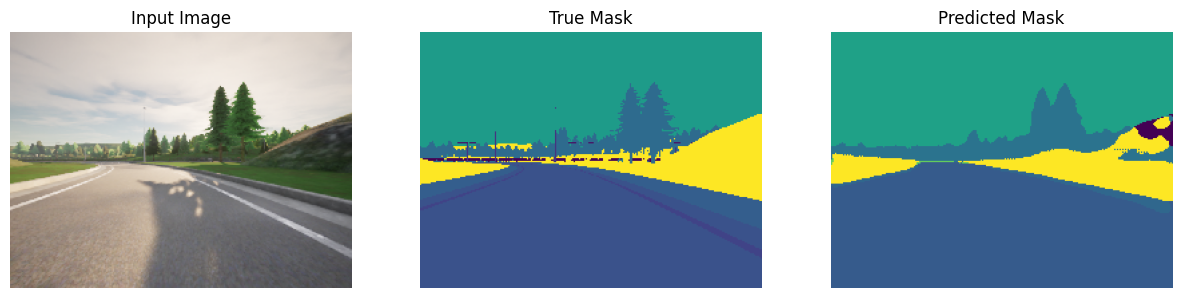

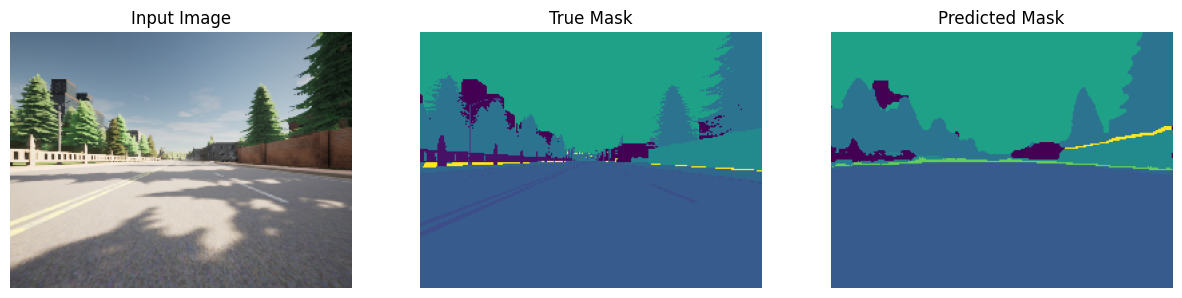

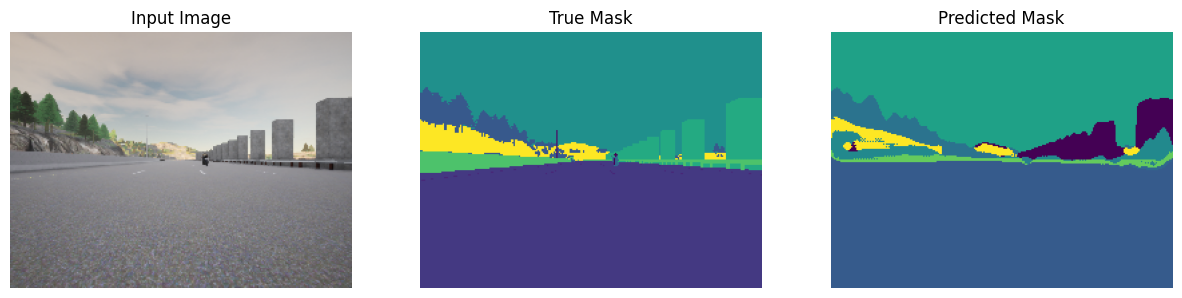

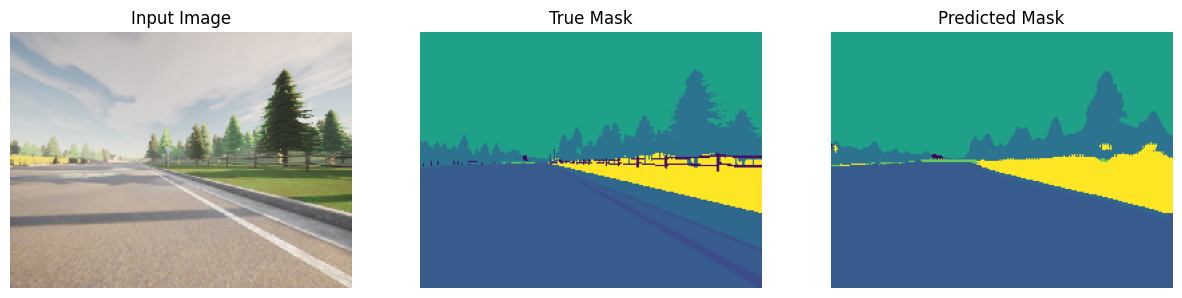

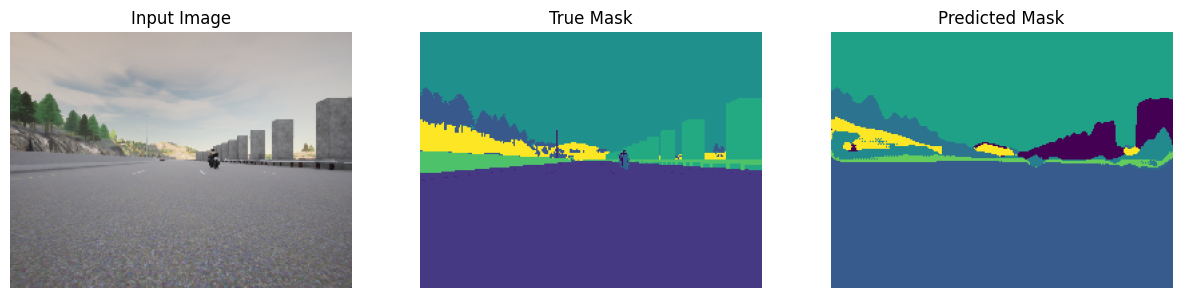

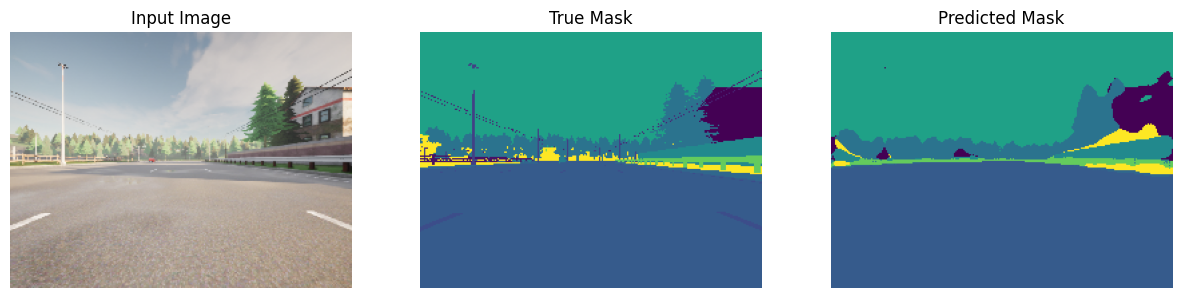

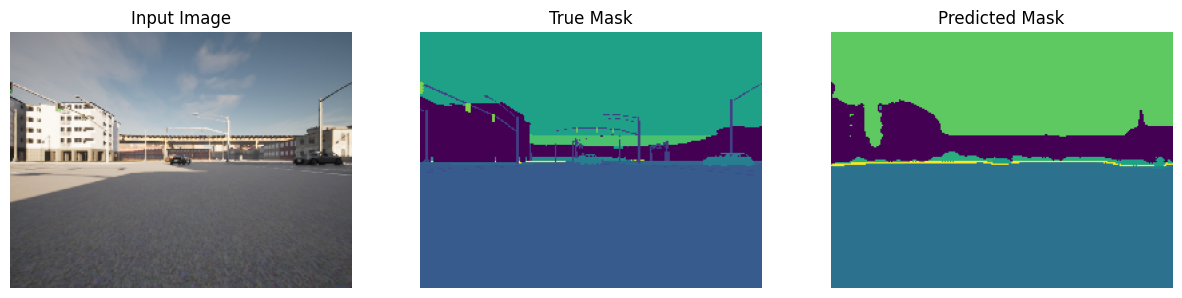

In [43]:
show_predictions(dataloader, device, 6)

<font color='blue'>
    
**What you should remember**:

* Semantic image segmentation predicts a label for every single pixel in an image
* U-Net uses an equal number of convolutional blocks and transposed convolutions for downsampling and upsampling
* Skip connections are used to prevent border pixel information loss and overfitting in U-Net